# Training Convolutional Variational Autoencoder for Anamoly Detection at L1Trigger

## Packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.initializers import glorot_uniform
from sklearn.metrics import roc_curve, auc

import keras_tuner
from keras_tuner import Hyperband

import joblib

Using TensorFlow backend.


In [2]:
#ZeroBias data for training
df_zb = pd.read_csv('L1TRegionDump.csv')
df_zb

,event,eta,phi,et,position,electron,tau
0,0,6,3,0,0,1,1
1,0,7,3,1,0,1,1
2,0,5,3,0,0,1,1
3,0,8,3,0,0,1,1
4,0,4,3,0,0,1,1
...,...,...,...,...,...,...,...
79573531,315767,11,14,0,0,1,1
79573532,315767,1,14,0,0,1,1
79573533,315767,12,14,0,0,1,1
79573534,315767,0,14,0,0,1,1


In [3]:
#Original ZB data is sorted by event # only, where eta and phi are not sorted properly
#Re-sort here for easier 2D plotting and data pre-processing later
#e.g. in each event block (252 rows), rank phi first from 17 to 0, then for each phi value rank eta from 0 to 13
df_zb = df_zb.sort_values(by = ['event', 'phi', 'eta'], ascending = [True, False, True])
df_zb

,event,eta,phi,et,position,electron,tau
124,0,0,17,7,10,0,0
122,0,1,17,0,0,1,1
120,0,2,17,0,0,1,1
118,0,3,17,1,15,1,1
116,0,4,17,1,13,1,1
...,...,...,...,...,...,...,...
79573415,315767,9,0,0,0,1,1
79573417,315767,10,0,0,0,1,1
79573419,315767,11,0,0,0,1,1
79573421,315767,12,0,0,0,1,1


In [4]:
#Simulated VBFH->bb signal for test inference only (not to be used in training)
df_vbfh = pd.read_csv('cms-vbfh.csv')
df_vbfh

,eta,phi,et,position,electron,tau
0,0,0,14,1,0,1
1,0,1,14,0,0,1
2,0,2,14,0,0,1
3,0,3,14,0,0,1
4,0,4,14,1,1,1
...,...,...,...,...,...,...
251995,13,13,0,0,0,0
251996,13,14,1,11,1,1
251997,13,15,0,0,0,1
251998,13,16,0,15,1,1


In [5]:
#VBFH csv file has the column 'event' missing
#Make one here and then sort the same way as above
vbfh_event_col = []
for i in range(round(df_vbfh.shape[0]/252)):
    for j in range(252):
        vbfh_event_col.append(i)

df_vbfh['event'] = vbfh_event_col
df_vbfh = df_vbfh.sort_values(by = ['event', 'phi', 'eta'], ascending = [True, False, True])
df_vbfh

,eta,phi,et,position,electron,tau,event
17,0,17,0,0,0,0,0
35,1,17,0,0,0,0,0
53,2,17,0,0,0,0,0
71,3,17,0,0,0,0,0
89,4,17,4,15,1,1,0
...,...,...,...,...,...,...,...
251910,9,0,0,0,0,0,999
251928,10,0,0,0,0,0,999
251946,11,0,0,0,0,0,999
251964,12,0,0,0,0,0,999


In [6]:
#Keep only (eta, phi, ET) as inputs for the moment
df_zb_reduced = df_zb.drop(columns = ['event', 'position', 'electron', 'tau'])
df_vbfh_reduced = df_vbfh.drop(columns = ['event', 'position', 'electron', 'tau'])

#Convert pandas dataframes to numpy arrays for easier manipulation
#Array shape: # of events, # of Calo regions, (eta, phi, ET)
df_zb_reduced = df_zb_reduced.to_numpy().reshape(round(df_zb.shape[0]/252), 252, 3)
df_vbfh_reduced = df_vbfh_reduced.to_numpy().reshape(round(df_vbfh.shape[0]/252), 252, 3)

df_zb_reduced = df_zb_reduced.astype(dtype = 'float64')
df_vbfh_reduced = df_vbfh_reduced.astype(dtype = 'float64')

In [7]:
#Partition the whole training set into train/val/test sets
X = df_zb_reduced

train_ratio = 0.3
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 123)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

In [8]:
X_train[:,:,2] = X_train[:,:,2]/X_train[:,:,2].max()
X_val[:,:,2] = X_val[:,:,2]/X_val[:,:,2].max()
X_test[:,:,2] = X_test[:,:,2]/X_test[:,:,2].max()

In [9]:
df_vbfh_reduced[:,:,2] = df_vbfh_reduced[:,:,2]/df_vbfh_reduced[:,:,2].max()

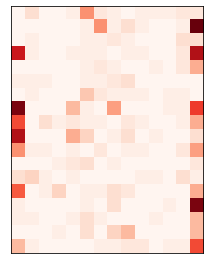

In [10]:
plt.figure(figsize=(15, 10))

ax = plt.subplot(2, 2, 1)
plt.imshow(X_train[35,:,2].reshape(18, 14), cmap = 'Reds')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

In [11]:
X_train_reshaped = np.zeros((X_train.shape[0], 18, 14, 1))
for i in range(X_train_reshaped.shape[0]):
    for j in range(18):
        for k in range(14):
            X_train_reshaped[i][j][k][0] = X_train[i][j*14+k][2]

X_val_reshaped = np.zeros((X_val.shape[0], 18, 14, 1))
for i in range(X_val_reshaped.shape[0]):
    for j in range(18):
        for k in range(14):
            X_val_reshaped[i][j][k][0] = X_val[i][j*14+k][2]

X_test_reshaped = np.zeros((X_test.shape[0], 18, 14, 1))
for i in range(X_test_reshaped.shape[0]):
    for j in range(18):
        for k in range(14):
            X_test_reshaped[i][j][k][0] = X_test[i][j*14+k][2]

df_vbfh_reshaped = np.zeros((df_vbfh_reduced.shape[0], 18, 14, 1))
for i in range(df_vbfh_reshaped.shape[0]):
    for j in range(18):
        for k in range(14):
            df_vbfh_reshaped[i][j][k][0] = df_vbfh_reduced[i][j*14+k][2]

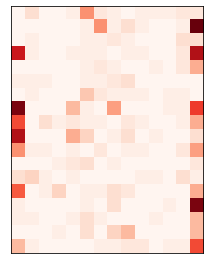

In [12]:
plt.figure(figsize=(15, 10))

ax = plt.subplot(2, 2, 1)
plt.imshow(X_train_reshaped[35,:,:,0].reshape(18, 14), cmap = 'Reds')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

## Convolutional autoencoder

In [13]:
encoder_input = keras.Input(shape = (18, 14, 1))

encoding = layers.Conv2D(20, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoder_input)
encoding = layers.MaxPooling2D((2, 2))(encoding)
encoding = layers.Conv2D(10, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoding)

encoder_output = layers.Conv2D(1, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoding)

encoder = keras.models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 14, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 14, 20)        200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 7, 20)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 7, 10)          1810      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 7, 1)           91        
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


In [14]:
decoding = layers.Conv2DTranspose(10, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoder_output)
decoding = layers.UpSampling2D((2, 2))(decoding)
decoding = layers.Conv2DTranspose(20, (3, 3), activation = 'relu', strides = 1, padding = 'same')(decoding)

decoder_output = layers.Conv2D(1, (3, 3), activation = 'sigmoid', strides = 1, padding = 'same')(decoding)

In [15]:
autoencoder = keras.Model(encoder_input, decoder_output)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 14, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 14, 20)        200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 7, 20)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 7, 10)          1810      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 7, 1)           91        
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 9, 7, 10)          100       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 18, 14, 10)        0   

In [16]:
autoencoder.compile(optimizer = 'adam', loss = "binary_crossentropy")

In [17]:
history = autoencoder.fit(X_train_reshaped, X_train_reshaped,
                          epochs = 5,
                          validation_data = (X_val_reshaped, X_val_reshaped),
                          batch_size = 256,
                          callbacks = [
                              keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 0, mode = "min")
                          ])

Train on 94730 samples, validate on 63154 samples
Epoch 1/5
94730/94730 [==============================] - 178s 2ms/sample - loss: 0.0798 - val_loss: 0.0151
Epoch 2/5
94730/94730 [==============================] - 172s 2ms/sample - loss: 0.0158 - val_loss: 0.0142
Epoch 3/5
94730/94730 [==============================] - 171s 2ms/sample - loss: 0.0154 - val_loss: 0.0140
Epoch 4/5
94730/94730 [==============================] - 171s 2ms/sample - loss: 0.0152 - val_loss: 0.0139
Epoch 5/5
94730/94730 [==============================] - 172s 2ms/sample - loss: 0.0150 - val_loss: 0.0137


Text(0, 0.5, 'Loss')

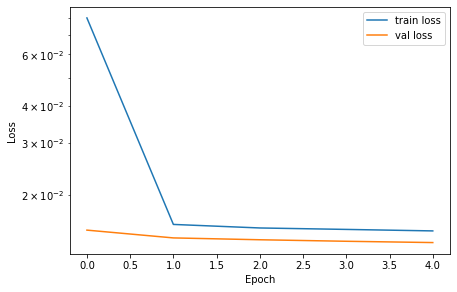

In [18]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [19]:
X_train_predict = autoencoder.predict(X_train_reshaped)
X_test_predict = autoencoder.predict(X_test_reshaped)
df_vbfh_predict = autoencoder.predict(df_vbfh_reshaped)

In [20]:
X_train_mse = ((X_train_predict - X_train_reshaped).reshape(X_train_reshaped.shape[0], 252))**2
X_train_mse = np.mean(X_train_mse, axis = 1)

X_test_mse = ((X_test_predict - X_test_reshaped).reshape(X_test_reshaped.shape[0], 252))**2
X_test_mse = np.mean(X_test_mse, axis = 1)

df_vbfh_mse = ((df_vbfh_predict - df_vbfh_reshaped).reshape(df_vbfh_reshaped.shape[0], 252))**2
df_vbfh_mse = np.mean(df_vbfh_mse, axis = 1)

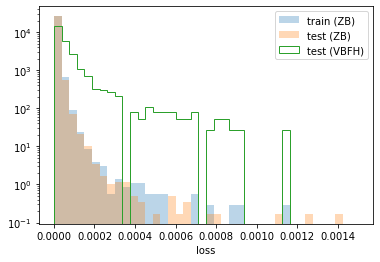

In [35]:
nbins = 40
rmin = 0.0
rmax = 0.0015
plt.hist(X_train_mse, density = 1, bins = nbins, alpha = 0.3, label = 'train (ZB)', log = True, range = (rmin, rmax))
plt.hist(X_test_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZB)', range = (rmin, rmax))
plt.hist(df_vbfh_mse, density = 1, bins = nbins, label = 'test (VBFH)', histtype = 'step', range = (rmin, rmax))
plt.legend()
plt.xlabel("loss")
plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

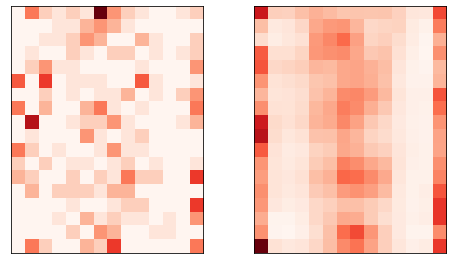

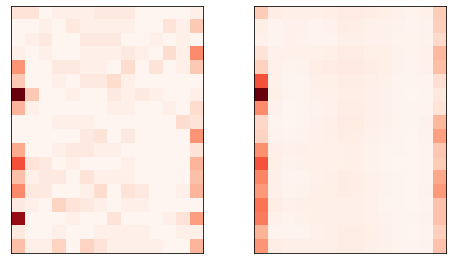

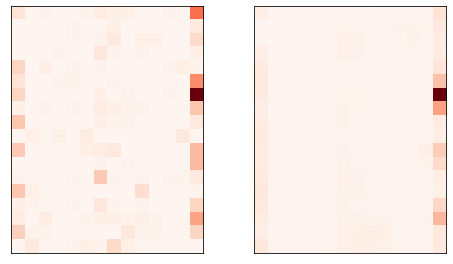

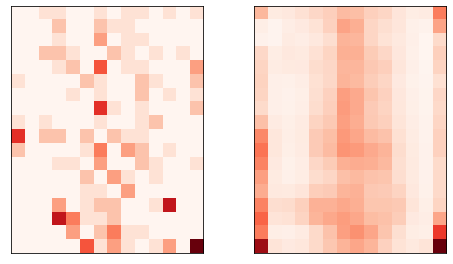

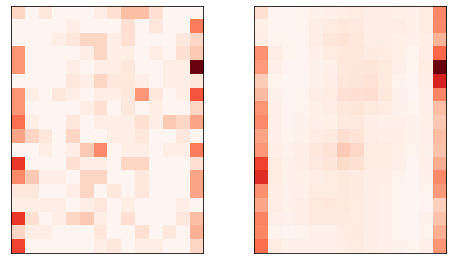

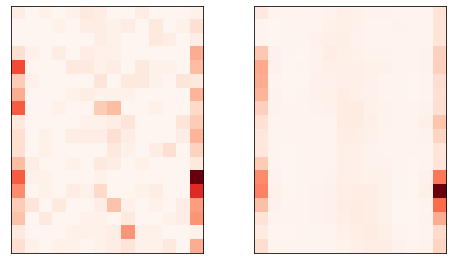

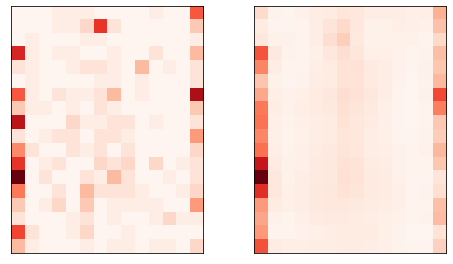

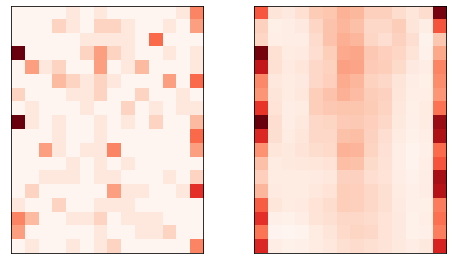

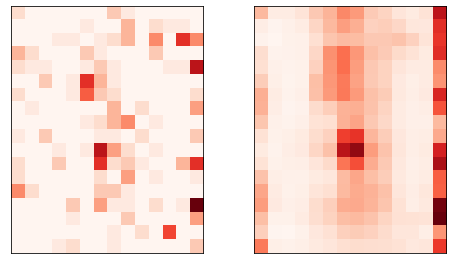

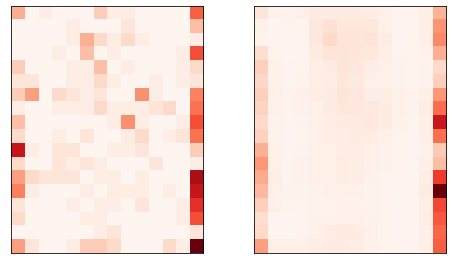

In [36]:
for i in range(10):
    plt.figure(figsize=(8, 10))
    ax = plt.subplot(2, 2, 1)
    plt.imshow(X_test_reshaped[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 2, 2)
    plt.imshow(X_test_predict[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.show()

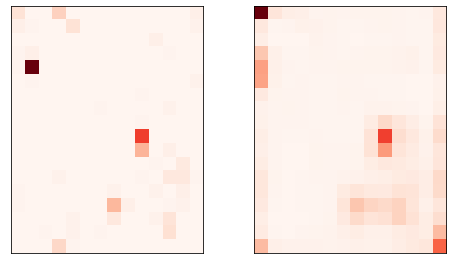

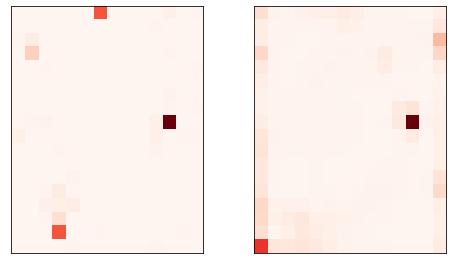

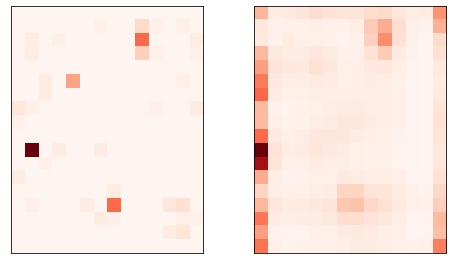

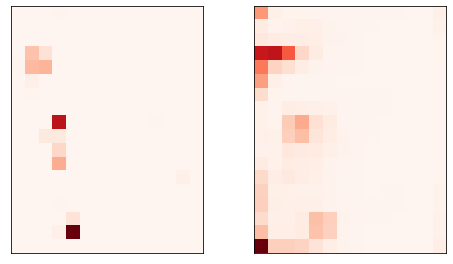

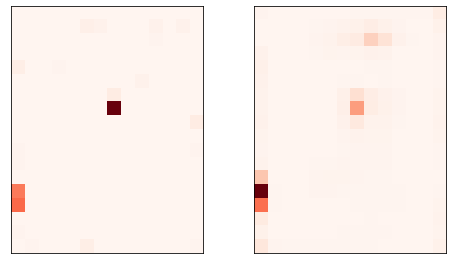

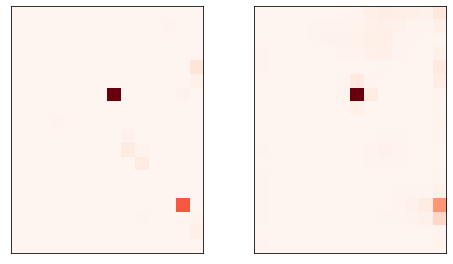

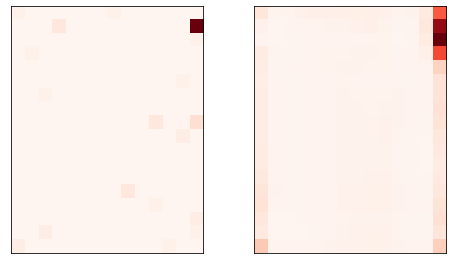

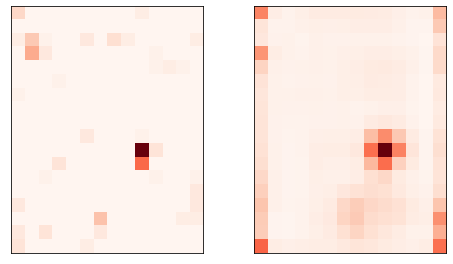

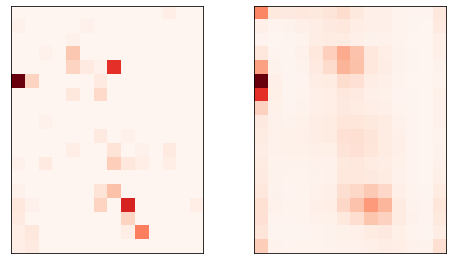

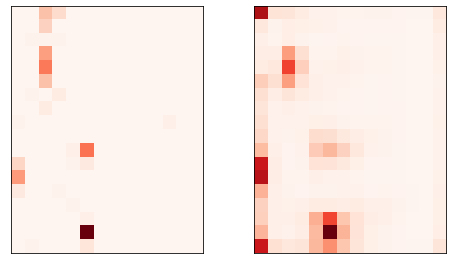

In [37]:
for i in range(100, 110):
    plt.figure(figsize=(8, 10))
    ax = plt.subplot(2, 2, 1)
    plt.imshow(df_vbfh_reshaped[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 2, 2)
    plt.imshow(df_vbfh_predict[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.show()

In [38]:
Y_vbfh = np.ones((df_vbfh_reshaped.shape[0], 1))
Y_test_zb = np.zeros((X_test_reshaped.shape[0], 1))
Y_true = np.concatenate((Y_vbfh, Y_test_zb))
Y_predict = np.concatenate((df_vbfh_mse, X_test_mse))

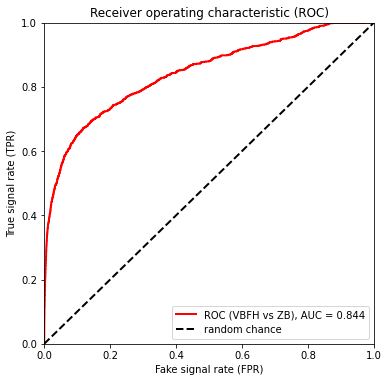

In [39]:
# Plot ROC
plt.figure(figsize = (13,13))
fpr, tpr, thresholds = roc_curve(Y_true, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC (VBFH vs ZB), AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
#axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB->L1T rate)')
#axes.set_xlim([0.0001, 1.0])
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_xscale(value = "log")
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

## Convolutional variational autoencoder

In [109]:
def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = keras.backend.random_normal(shape = keras.backend.shape(mu), mean = 0.0, stddev = 1.0)
    random_sample = mu + keras.backend.exp(log_variance/2) * epsilon
    return random_sample

In [182]:
latent_dim = 30
encoder_inputs = keras.Input(shape = (18, 14, 1))

encoding = layers.Conv2D(15, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoder_inputs)
encoding = layers.MaxPooling2D((2, 2), padding = 'same')(encoding)
encoding = layers.Conv2D(5, (3, 3), activation = 'relu', strides = 1, padding = 'same')(encoding)
encoding = layers.Flatten()(encoding)
encoding = layers.Dense(latent_dim + latent_dim)(encoding)

z_mean = layers.Dense(latent_dim, name = 'z_mean')(encoding)
z_log_var = layers.Dense(latent_dim, name = 'z_log_var')(encoding)

encoder_mu_log_var_model = keras.Model(encoder_inputs, (z_mean, z_log_var))

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, z, name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 18, 14, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 18, 14, 15)   150         input_35[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 9, 7, 15)     0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 9, 7, 5)      680         max_pooling2d_18[0][0]           
____________________________________________________________________________________________

In [183]:
latent_inputs = keras.Input(shape = (latent_dim,))

decoding = layers.Dense(9 * 7 * 5)(latent_inputs)
decoding = layers.Reshape((9, 7, 5))(decoding)
decoding = layers.Conv2DTranspose(5, (3, 3), activation = 'relu', strides = 1, padding = 'same')(decoding)
decoding = layers.UpSampling2D((2, 2))(decoding)
decoding = layers.Conv2DTranspose(15, (3, 3), activation = 'relu', strides = 1, padding = 'same')(decoding)

decoder_outputs = layers.Conv2DTranspose(1, (3, 3), activation = 'sigmoid', strides = 1, padding = 'same')(decoding)

decoder = keras.Model(latent_inputs, decoder_outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
dense_19 (Dense)             (None, 315)               9765      
_________________________________________________________________
reshape_15 (Reshape)         (None, 9, 7, 5)           0         
_________________________________________________________________
conv2d_transpose_47 (Conv2DT (None, 9, 7, 5)           230       
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 18, 14, 5)         0         
_________________________________________________________________
conv2d_transpose_48 (Conv2DT (None, 18, 14, 15)        690       
_________________________________________________________________
conv2d_transpose_49 (Conv2DT (None, 18, 14, 1)         136 

In [184]:
vae_input = layers.Input(shape=(18, 14, 1), name = "VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = keras.models.Model(vae_input, vae_decoder_output, name = "VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 18, 14, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 30)                23450     
_________________________________________________________________
decoder (Model)              (None, 18, 14, 1)         10821     
Total params: 34,271
Trainable params: 34,271
Non-trainable params: 0
_________________________________________________________________


In [186]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 100
        reconstruction_loss = keras.backend.mean(keras.backend.square(y_true - y_predict), axis = [1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis = 1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis = 1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

vae.compile(optimizer = 'adam', loss = loss_func(z_mean, z_log_var))

In [187]:
history = vae.fit(X_train_reshaped, X_train_reshaped,
                  epochs = 3,
                  validation_data = (X_val_reshaped, X_val_reshaped),
                  batch_size = 256)

Train on 94730 samples, validate on 63154 samples
Epoch 1/3
94730/94730 [==============================] - 99s 1ms/sample - loss: 0.7730 - val_loss: 0.0033
Epoch 2/3
94730/94730 [==============================] - 95s 1ms/sample - loss: 0.0040 - val_loss: 0.0032
Epoch 3/3
94730/94730 [==============================] - 95s 1ms/sample - loss: 0.0040 - val_loss: 0.0032


Text(0, 0.5, 'Loss')

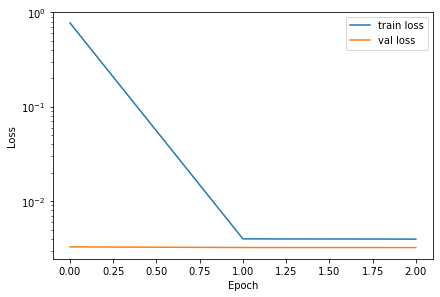

In [198]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [189]:
X_train_predict = vae.predict(X_train_reshaped)
X_test_predict = vae.predict(X_test_reshaped)
df_vbfh_predict = vae.predict(df_vbfh_reshaped)

In [190]:
X_train_mse = ((X_train_predict - X_train_reshaped).reshape(X_train_reshaped.shape[0], 252))**2
X_train_mse = np.mean(X_train_mse, axis = 1)

X_test_mse = ((X_test_predict - X_test_reshaped).reshape(X_test_reshaped.shape[0], 252))**2
X_test_mse = np.mean(X_test_mse, axis = 1)

df_vbfh_mse = ((df_vbfh_predict - df_vbfh_reshaped).reshape(df_vbfh_reshaped.shape[0], 252))**2
df_vbfh_mse = np.mean(df_vbfh_mse, axis = 1)

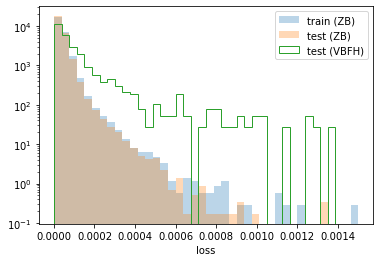

In [191]:
nbins = 40
rmin = 0.0
rmax = 0.0015
plt.hist(X_train_mse, density = 1, bins = nbins, alpha = 0.3, label = 'train (ZB)', log = True, range = (rmin, rmax))
plt.hist(X_test_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZB)', range = (rmin, rmax))
plt.hist(df_vbfh_mse, density = 1, bins = nbins, label = 'test (VBFH)', histtype = 'step', range = (rmin, rmax))
plt.legend()
plt.xlabel("loss")
plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

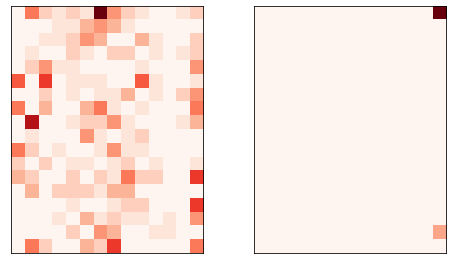

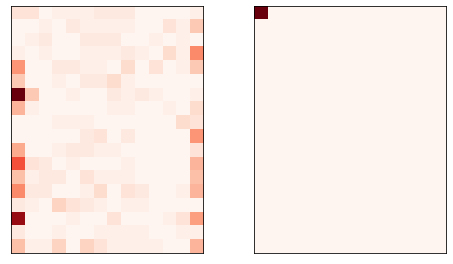

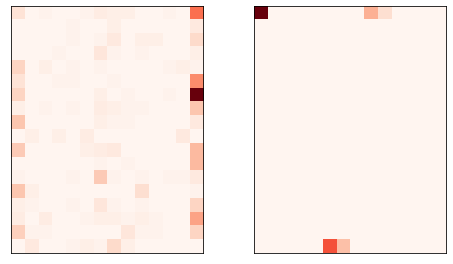

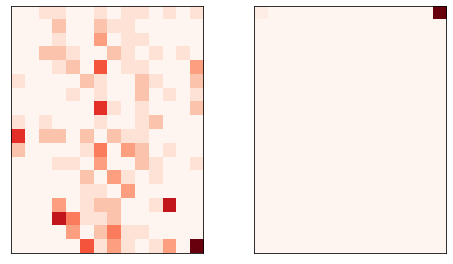

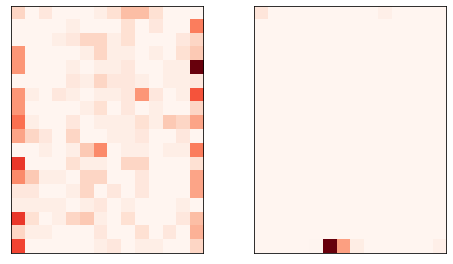

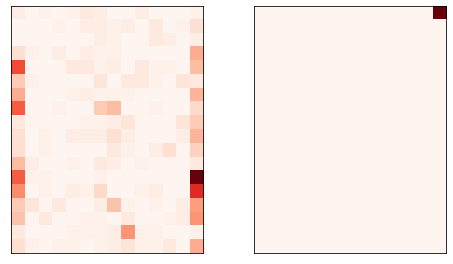

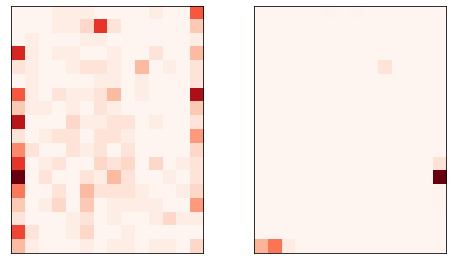

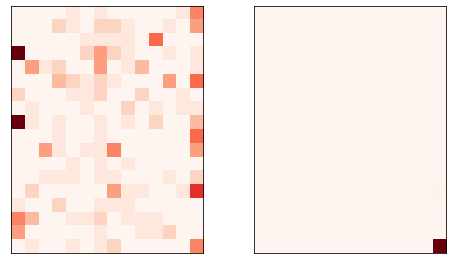

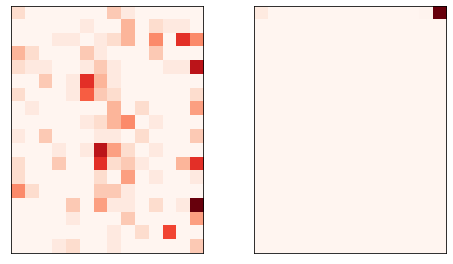

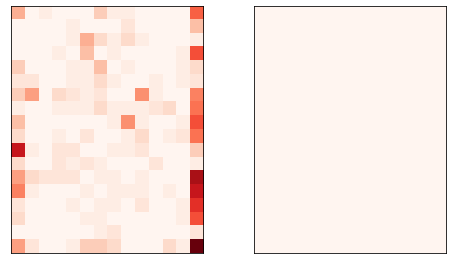

In [192]:
for i in range(10):
    plt.figure(figsize=(8, 10))
    ax = plt.subplot(2, 2, 1)
    plt.imshow(X_test_reshaped[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 2, 2)
    plt.imshow(X_test_predict[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.show()

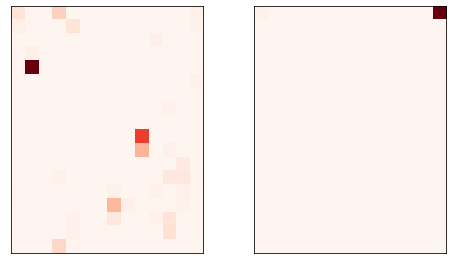

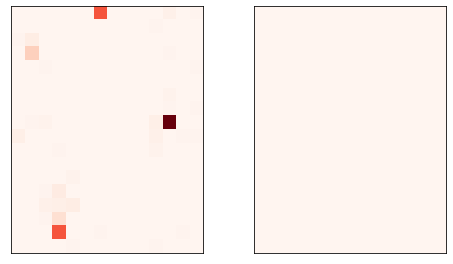

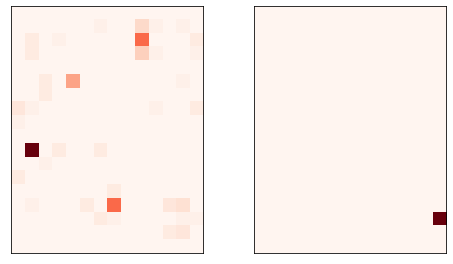

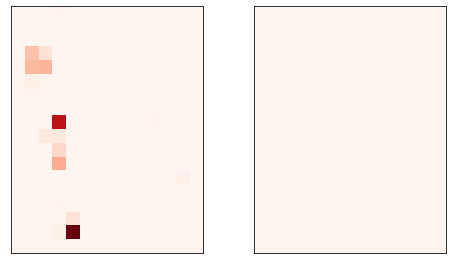

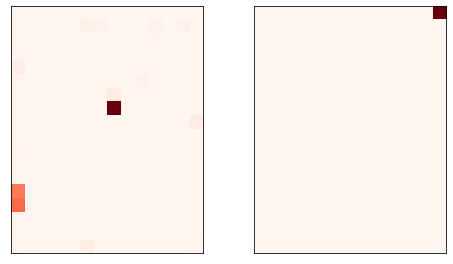

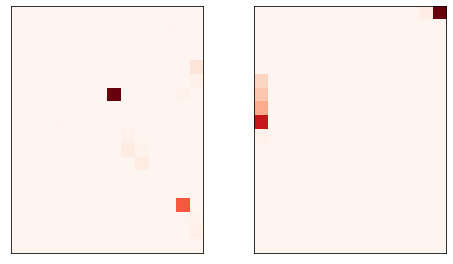

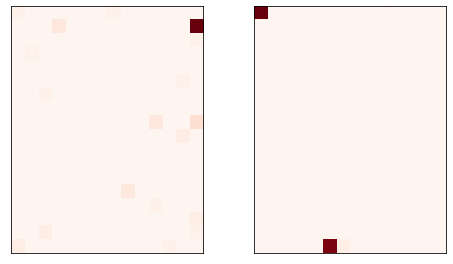

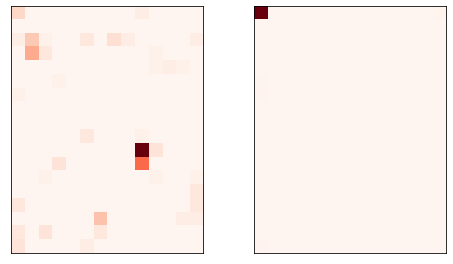

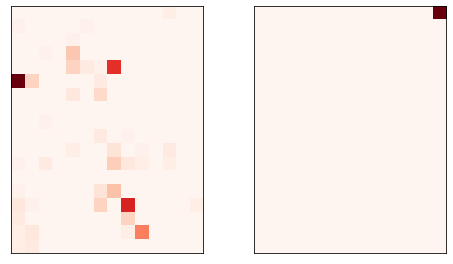

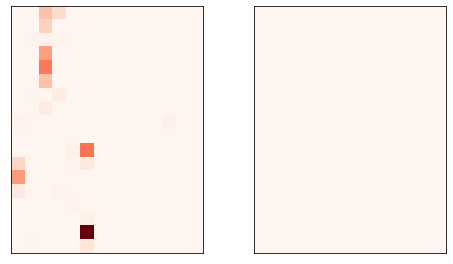

In [193]:
for i in range(100, 110):
    plt.figure(figsize=(8, 10))
    ax = plt.subplot(2, 2, 1)
    plt.imshow(df_vbfh_reshaped[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 2, 2)
    plt.imshow(df_vbfh_predict[i,:,:,0].reshape(18, 14), cmap = 'Reds')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.show()

In [194]:
X_train_encoded = encoder.predict(X_train_reshaped, batch_size = 128)
X_test_encoded = encoder.predict(X_test_reshaped, batch_size = 128)
df_vbfh_encoded = encoder.predict(df_vbfh_reshaped, batch_size = 128)

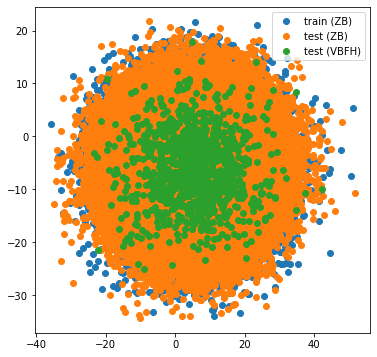

In [196]:
i = 5
j = 6
alpha_value = 1
plt.figure(figsize=(6, 6))
plt.scatter(X_train_encoded[:, i], X_train_encoded[:, j], alpha = alpha_value, label = 'train (ZB)')
plt.scatter(X_test_encoded[:, i], X_test_encoded[:, j], alpha = alpha_value, label = 'test (ZB)')
plt.scatter(df_vbfh_encoded[:, i], df_vbfh_encoded[:, j], alpha = alpha_value, label = 'test (VBFH)')
plt.legend()
#plt.colorbar()
plt.show()

In [121]:
Y_vbfh = np.ones((df_vbfh_reshaped.shape[0], 1))
Y_test_zb = np.zeros((X_test_reshaped.shape[0], 1))
Y_true = np.concatenate((Y_vbfh, Y_test_zb))
Y_predict = np.concatenate((df_vbfh_mse, X_test_mse))

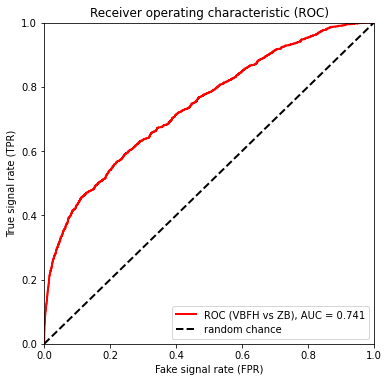

In [123]:
# Plot ROC
plt.figure(figsize = (13,13))
fpr, tpr, thresholds = roc_curve(Y_true, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC (VBFH vs ZB), AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
#axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB->L1T rate)')
#axes.set_xlim([0.0001, 1.0])
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_xscale(value = "log")
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()